## Heirarchical Drift Diffusion Model Analysis

In this analysis, we fit a version of the diffusion model that takes participant-level variability into account. As Wiecki et al. (2013) put it, 

"Hierarchical Bayesian methods provide a remedy for this problem by allowing group and subject parameters to be estimated simultaneously at different hierarchical levels ([LeeWagenmakers13], [Kruschke10], [VandekerckhoveTuerlinckxLee11]). Subject parameters are assumed to be drawn from a group distribution, and to the degree that subject are similar to each other, the variance in the group distribution will be estimated to be small, which reciprocally has a greater influence on constraining parameter estimates of any individual. Even in this scenario, the method still allows the posterior for any given individual subject to differ substantially from that of the rest of the group given sufficient data to overwhelm the group prior. Thus the method capitalizes on statistical strength shared across the individuals, and can do so to different degrees even within the same sample and model, depending on the extent to which subjects are similar to each other in one parameter vs. another."

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hddm
write_path = "../../../data/3_final_merged_data/hddm_output/kids/"

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
def model_to_df(model, param_list):
    """
    Extract posterior samples for particular parameters 
    from an hddm model object and returns as pandas dataframe
    """
    node_names = []
    samples = []

    for node in model.nodes_db.node[param_list]:
        node_names.append(str(node))
        samples.append(node.trace())    

    return pd.DataFrame(dict(zip(node_names, samples)))

In [3]:
# Load and arrange data for analysis
data = hddm.load_csv("../../../data/3_final_merged_data/ewma_output/speed_acc_kids_trio_ewma_results.csv")
data = data.dropna(subset = ['RT'])
data['subj_idx'] = data['Sub.Num']
data['rt'] = data['RT']
data['response'] = data['correct']

In [8]:
# Separate adult and kid data
data_kids = data[data.age_code == "child"]
data_adults = data[data.age_code == "adult"]
# filter to remove extreme guesses
data_kids = data_kids[(data_kids.guess == "response")]
# remove object and bullseye data
data_kids = data_kids[(data_kids['stimuli'] == "Face") | (data_kids['stimuli'] == "ASL") ]

In [5]:
data_kids = hddm.utils.flip_errors(data_kids)
data_kids.head(5)

,Sub.Num,Tr.Num,stimuli,age_code,correct,Months,clean_target_img,RT,condition,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
77,30047,15,ASL,child,1,35,birdy,0.733,ASL,0.733,response,1,0.01,cs,0.57,30047,1
78,30010,13,ASL,child,1,44,teddy,0.767,ASL,0.767,response,1,0.01,cs,0.57,30010,1
82,30019,18,ASL,child,1,29,shoe,0.767,ASL,0.767,response,1,0.01,cs,0.57,30019,1
84,30019,24,ASL,child,1,29,car,0.767,ASL,0.767,response,1,0.01,cs,0.57,30019,1
85,30019,26,ASL,child,1,29,shoe,0.767,ASL,0.767,response,1,0.01,cs,0.57,30019,1


In [7]:
data_adults = hddm.utils.flip_errors(data_adults)
data_adults.head(5)

,Sub.Num,Tr.Num,stimuli,age_code,correct,Months,clean_target_img,RT,condition,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response


## Fit model with variable drift and boundry separation

Here we fit the ddm for each participant, but now we allow the drift rate and the boundary separation to vary across the four conditions. We also consider the possibility that 5% of the data could be generated by a different process (i.e., outliers). From the HDDM documentation:

"What we can do instead is fit a mixture model which assumes that outliers come from a uniform distribution. (Note, outliers do not have to be very fast or very slow, and the above example is just an obvious illustration. Some proportion of the trials can be assumed to simply come from a different process for which we make no assumptions about its generation, and hence use a uniform distribution. This allows the model to find the best DDM parameters that capture the majority of trials). Here, we specify that we expect roughly 5% outliers in our data."

In [10]:
m_stim = hddm.HDDM(data_kids, depends_on={'v': 'stimuli', 'a': 'stimuli'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=100)

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1001 of 1000 complete in 95.0 sec

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Text(0.5,1,'Posterior of drift-rate group means')

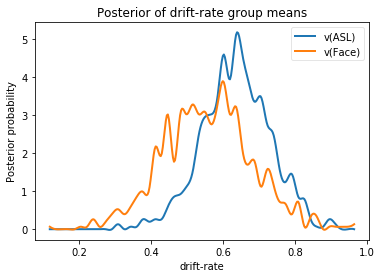

In [11]:
drift_ASL, drift_Face = m_stim.nodes_db.node[['v(ASL)', 'v(Face)']]
hddm.analyze.plot_posterior_nodes([drift_ASL, drift_Face])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

Text(0.5,1,'Posterior distribution of boundary separation')

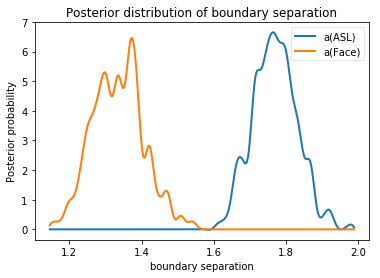

In [12]:
boundary_ASL, boundary_Face = m_stim.nodes_db.node[['a(ASL)', 'a(Face)']]
hddm.analyze.plot_posterior_nodes([boundary_ASL, boundary_Face])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation')

In [113]:
trio_df = model_to_df(m_stim, param_list= ['a(ASL)', 'a(Face)', 'v(ASL)', 'v(Face)'])
trio_df['experiment'] = "trio"
trio_df['age_code'] = "children"
trio_df.head()

,a(ASL),a(Face),v(ASL),v(Face),experiment,age_code
0,1.802530,1.300729,0.588560,0.595025,trio,children
1,1.841077,1.269235,0.620032,0.813783,trio,children
2,1.798861,1.469107,0.625308,0.708359,trio,children
3,1.800096,1.260873,0.676346,0.793566,trio,children
4,1.791964,1.347059,0.660535,0.863777,trio,children


In [23]:
# take a look at participant-level parameter estimates
#stats = m_stim.gen_stats()

stats[stats.index.isin(['a(Face)', 'v(Face)', 'v(ASL)'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a(Face),1.34028,0.0700568,1.21216,1.29098,1.34112,1.3851,1.48319,0.00363068
v(ASL),0.635186,0.0928153,0.448807,0.575985,0.637368,0.698443,0.81321,0.00368107
v(Face),0.557646,0.121556,0.317361,0.476326,0.556808,0.634223,0.802152,0.00613476


In [123]:
# save to csv
trio_df.to_csv("../../../data/3_final_merged_data/hddm_output/hddm_posterior_samples_trio.csv", sep='\t')

## Fit ASL adult data

In [131]:
m_trio_adults = hddm.HDDM(data_adults, depends_on={'v': 'stimuli', 'a': 'stimuli'})
m_trio_adults.find_starting_values()
m_trio_adults.sample(10000, burn=100)

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10000 of 10000 complete in 471.7 sec

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Text(0.5,1,'Posterior distribution of boundary separation')

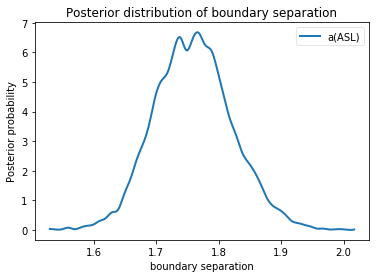

In [132]:
boundary_ASL_adults, drift_ASL_adults = m_stim.nodes_db.node[['a(ASL)', 'v(ASL)']]
hddm.analyze.plot_posterior_nodes([boundary_ASL_adults])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation')

In [133]:
trio_df_adults = model_to_df(m_stim, param_list= ['a(ASL)', 'v(ASL)'])
trio_df_adults['experiment'] = "trio"
trio_df_adults['age_code'] = "adults"
trio_df_adults.head()

,a(ASL),v(ASL),experiment,age_code
0,1.802530,0.588560,trio,adults
1,1.841077,0.620032,trio,adults
2,1.798861,0.625308,trio,adults
3,1.800096,0.676346,trio,adults
4,1.791964,0.660535,trio,adults


In [134]:
trio_df_adults.to_csv("../../../data/3_final_merged_data/hddm_output/hddm_posterior_samples_trio_adults.csv", sep='\t')

# Fit HDDM to kid gaze experiment

Next, we fit the same HDDM for the kid data from an experiment where we manipulated the presence of gaze after the noun cue.

In [19]:
# Loading and arranging data for analysis
data_kid_gaze = hddm.load_csv("../../../data/3_final_merged_data/ewma_output/speed_acc_kids_gaze_ewma_results.csv")
data_kid_gaze = data_kid_gaze.dropna(subset = ['rt'])
data_kid_gaze['subj_idx'] = data_kid_gaze['subid']
data_kid_gaze['response'] = data_kid_gaze['correct']

In [20]:
# filter to remove guesses as flagged by the EWMA model
data_kid_gaze = data_kid_gaze[(data_kid_gaze.guess == "response")]
data_kid_gaze = hddm.utils.flip_errors(data_kid_gaze)
data_kid_gaze.head(5)

,subid,tr.num,gaze_condition,correct,age,age_group,RT,condition,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
212,25,7,gaze,1,1929.0,5,0.442,gaze,0.44,response,1,0.01,cs,0.58,25,1
213,26,7,gaze,1,1789.0,4,0.442,gaze,0.44,response,1,0.01,cs,0.58,26,1
214,34,25,gaze,1,2016.0,5,0.442,gaze,0.44,response,1,0.02,cs,0.59,34,1
215,45,13,gaze,1,NaN,3,0.442,gaze,0.44,response,1,0.02,cs,0.59,45,1
216,15,8,gaze,1,1077.0,2,0.467,gaze,0.47,response,1,0.02,cs,0.59,15,1


In [21]:
# fit model for kid gaze data
m_kid_gaze = hddm.HDDM(data_kid_gaze, depends_on={'v': 'condition', 'a': 'condition', 't': 'condition'})
m_kid_gaze.find_starting_values()
m_kid_gaze.sample(10000, burn=100)

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10000 of 10000 complete in 976.3 sec

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Text(0.5,1,'Posterior of drift-rate group means (Gaze kids)')

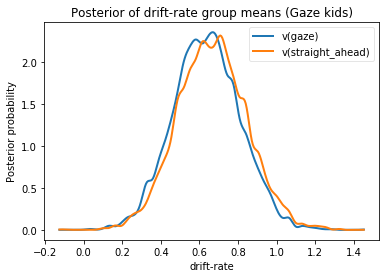

In [60]:
# plot drift
drift_gaze_kid, drift_straight_ahead_kid = m_kid_gaze.nodes_db.node[['v(gaze)', 'v(straight_ahead)']]
hddm.analyze.plot_posterior_nodes([drift_gaze_kid, drift_straight_ahead_kid])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means (Gaze kids)')

Text(0.5,1,'Posterior distribution of boundary separation (Gaze kids)')

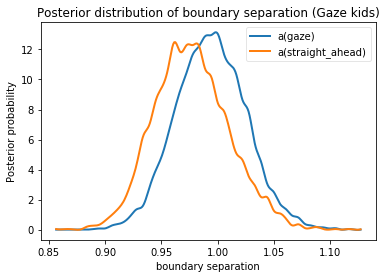

In [23]:
# plot boundary
boundary_gaze_kid, boundary_straight_ahead_kid = m_kid_gaze.nodes_db.node[['a(gaze)', 'a(straight_ahead)']]
hddm.analyze.plot_posterior_nodes([boundary_gaze_kid, boundary_straight_ahead_kid])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation (Gaze kids)')

In [115]:
gaze_kids_df = model_to_df(m_kid_gaze, param_list= ['a(gaze)', 'a(straight_ahead)', 'v(gaze)', 'v(straight_ahead)'])
gaze_kids_df['experiment'] = "gaze"
gaze_kids_df['age_code'] = "children"
gaze_kids_df.head()

,a(gaze),a(straight_ahead),v(gaze),v(straight_ahead),experiment,age_code
0,1.018602,0.979535,0.791597,0.700873,gaze,children
1,1.015484,0.951262,0.989198,0.737575,gaze,children
2,1.007720,0.978018,1.055092,0.500328,gaze,children
3,1.031080,0.987834,0.937786,0.523080,gaze,children
4,1.066255,0.977084,0.947968,0.560994,gaze,children


In [124]:
gaze_kids_df.to_csv("../../../data/3_final_merged_data/hddm_output/hddm_posterior_samples_gaze_kids.csv", sep='\t')

# Fit HDDM to kid noise data

Next, we fit the same HDDM for the kid data from two experiments manipulating the presence of gaze after the noun cue.

In [24]:
# read data
data_kid_noise = hddm.load_csv("../../../data/3_final_merged_data/ewma_output/speed_acc_kids_noise_ewma_results.csv")
data_kid_noise = data_kid_noise.dropna(subset = ['rt'])
data_kid_noise['subj_idx'] = data_kid_noise['subid']
data_kid_noise['response'] = data_kid_noise['correct']

# filter to remove guesses as flagged by the EWMA model
data_kid_noise = data_kid_noise[(data_kid_noise.guess == "response")]
data_kid_noise = hddm.utils.flip_errors(data_kid_noise)
data_kid_noise.head(5)

,subid,tr.num,noise_condition,correct,age,age_group,RT,condition,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
228,11,2,clear,1,1695.0,4,0.475,clear,0.48,response,1,0.01,cs,0.58,11,1
231,20,5,clear,1,2088.0,5,0.476,clear,0.48,response,1,0.01,cs,0.58,20,1
233,33,7,clear,1,NaN,5,0.500,clear,0.50,response,1,0.01,cs,0.58,33,1
234,46,11,clear,1,NaN,5,0.500,clear,0.50,response,1,0.01,cs,0.58,46,1
235,1,27,clear,0,1770.0,4,0.501,clear,-0.50,response,1,0.01,cs,0.58,1,0


In [25]:
# fit model for kid noise data
m_kid_noise = hddm.HDDM(data_kid_noise, depends_on={'v': 'condition', 'a': 'condition', 't': 'condition'})
m_kid_noise.find_starting_values()
m_kid_noise.sample(10000, burn=100)

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10000 of 10000 complete in 1170.1 sec

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Text(0.5,1,'Posterior of drift-rate group means (Noise kids)')

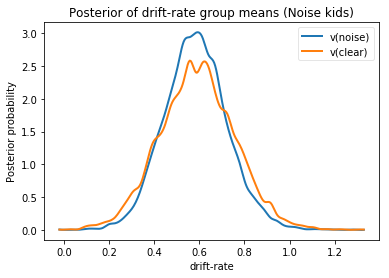

In [26]:
# plot drift
drift_noise_kid, drift_clear_kid = m_kid_noise.nodes_db.node[['v(noise)', 'v(clear)']]
hddm.analyze.plot_posterior_nodes([drift_noise_kid, drift_clear_kid])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means (Noise kids)')

Text(0.5,1,'Posterior distribution of boundary separation (Noise kids)')

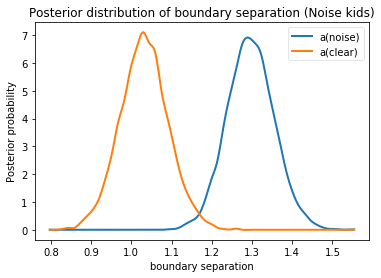

In [116]:
# plot boundary
boundary_noise_kid, boundary_clear_kid = m_kid_noise.nodes_db.node[['a(noise)', 'a(clear)']]
hddm.analyze.plot_posterior_nodes([boundary_noise_kid, boundary_clear_kid])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation (Noise kids)')

In [117]:
noise_kids_df = model_to_df(m_kid_noise, param_list= ['a(noise)', 'a(clear)', 'v(noise)', 'v(clear)'])
noise_kids_df['experiment'] = "noise"
noise_kids_df['age_code'] = "children"
noise_kids_df.head()

,a(clear),a(noise),v(clear),v(noise),experiment,age_code
0,1.012610,1.221943,0.474190,0.346866,noise,children
1,1.075038,1.244258,0.549644,0.505556,noise,children
2,1.151165,1.207016,0.636079,0.509921,noise,children
3,1.024329,1.285914,0.700074,0.571713,noise,children
4,0.972530,1.331325,0.653216,0.684532,noise,children


In [125]:
noise_kids_df.to_csv("../../../data/3_final_merged_data/hddm_output/hddm_posterior_samples_noise_kids.csv", sep='\t')

# Fit HDDM to adult text data

Next, we fit the same HDDM for the adult data with the four different center stimulus types: face, bullseye, text, and text-no-audio

In [28]:
# read data
data_adults = hddm.load_csv("../../../data/3_final_merged_data/ewma_output/speed_acc_adult_text_ewma_results.csv")
data_adults = data_adults.dropna(subset = ['RT'])
data_adults['subj_idx'] = data_adults['subid']
data_adults['rt'] = data_adults['RT']
data_adults['response'] = data_adults['correct']

# filter to remove guesses as flagged by the EWMA model
data_adults = data_adults[(data_adults.guess == "response")]
data_adults = hddm.utils.flip_errors(data_adults)
data_adults.head(5)

,subid,tr.num,condition,correct,RT,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
194,11_02_05,52,bullseye,1,0.497,0.497,response,1,0.01,cs,0.62,11_02_05,1
195,11_02_07,44,bullseye,1,0.497,0.497,response,1,0.01,cs,0.62,11_02_07,1
196,11_02_08,27,bullseye,1,0.497,0.497,response,1,0.01,cs,0.62,11_02_08,1
197,11_02_08,30,bullseye,1,0.497,0.497,response,1,0.02,cs,0.63,11_02_08,1
198,11_02_08,36,bullseye,1,0.497,0.497,response,1,0.02,cs,0.63,11_02_08,1


In [29]:
# fit model for adult data
m_adults = hddm.HDDM(data_adults, depends_on={'v': 'condition', 'a': 'condition', 't': 'condition'})
m_adults.find_starting_values()
m_adults.sample(10000, burn=100)

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10000 of 10000 complete in 1360.3 sec

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Text(0.5,1,'Posterior of drift-rate group means (Adult Text)')

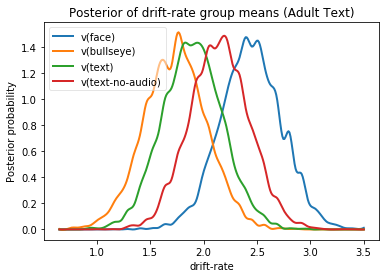

In [30]:
# plot drift
drift_face_adult, drift_bull_adult, drift_text_adult, drift_text_no_audio_adult = m_adults.nodes_db.node[['v(face)', 'v(bullseye)', 'v(text)', 'v(text-no-audio)']]
hddm.analyze.plot_posterior_nodes([drift_face_adult, drift_bull_adult, drift_text_adult, drift_text_no_audio_adult])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means (Adult Text)')

Text(0.5,1,'Posterior distribution of boundary separation (Adult Text)')

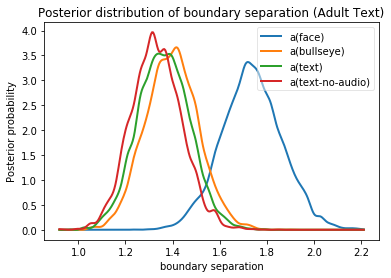

In [73]:
# plot boundary separation
boundary_face_adult, boundary_bull_adult, boundary_text_adult, boundary_text_no_audio_adult = m_adults.nodes_db.node[['a(face)', 'a(bullseye)', 'a(text)', 'a(text-no-audio)']]
hddm.analyze.plot_posterior_nodes([boundary_face_adult, boundary_bull_adult, boundary_text_adult, boundary_text_no_audio_adult])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation (Adult Text)')

In [100]:
# write variable drift model output to csv
drift_face_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_face_adult.csv", sep=',', format='%10.5f')
drift_bull_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_bull_adult.csv", sep=',', format='%10.5f')
drift_text_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_text_adult.csv", sep=',', format='%10.5f')
drift_text_no_audio_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_text_no_audio_adult.csv", sep=',', format='%10.5f')
# write boundary separation
boundary_face_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_face_adult.csv", sep=',', format='%10.5f')
boundary_bull_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_bull_adult.csv", sep=',', format='%10.5f')
boundary_text_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_text_adult.csv", sep=',', format='%10.5f')
boundary_text_no_audio_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_text_no_audio_adult.csv", sep=',', format='%10.5f')

In [118]:
text_adults_df = model_to_df(m_adults, param_list= ['a(face)', 'a(bullseye)', 'a(text)', 'a(text-no-audio)', 'v(face)', 'v(bullseye)', 'v(text)', 'v(text-no-audio)'])
text_adults_df['experiment'] = "text"
text_adults_df['age_code'] = "adults"
text_adults_df.head()

,a(bullseye),a(face),a(text),a(text-no-audio),v(bullseye),v(face),v(text),v(text-no-audio),experiment,age_code
0,1.552297,1.696221,1.365357,1.242022,1.617905,2.506204,1.969812,3.381523,text,adults
1,1.463038,1.912009,1.560283,1.368864,1.780051,1.756335,1.826894,2.216897,text,adults
2,1.534934,1.475458,1.138356,1.404412,1.810703,2.077431,2.295097,2.091987,text,adults
3,1.511685,1.646915,1.484035,1.325148,1.480958,2.989118,2.369812,2.297013,text,adults
4,1.502648,1.691258,1.519794,1.357831,1.691239,2.006405,2.317510,2.067397,text,adults


In [121]:
text_adults_df.to_csv("../../../data/3_final_merged_data/hddm_output/hddm_posterior_samples_text_adults.csv", sep='\t')

# Fit HDDM to adult noise & gaze data

Next, we fit the same HDDM for the adult data with the four different conditions: noise_gaze, noise_straight_ahead, clear_gaze, clear_straight_ahead.

In [32]:
# read data
data_adults_ng = hddm.load_csv("../../../data/3_final_merged_data/ewma_output/speed_acc_adult_ng_ewma_results.csv")
data_adults_ng = data_adults_ng.dropna(subset = ['RT'])
data_adults_ng['subj_idx'] = data_adults_ng['subid']
data_adults_ng['response'] = data_adults_ng['correct']

# filter to remove guesses as flagged by the EWMA model
data_adults_ng = data_adults_ng[(data_adults_ng.guess == "response")]
data_adults_ng = hddm.utils.flip_errors(data_adults_ng)
data_adults_ng.head(5)

,subid,tr.num,condition_long,correct,RT,condition,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
47,13,30,gaze_clear,1,0.310,gaze_clear,0.31,response,1,0.01,cs,0.59,13,1
48,33,35,gaze_clear,1,0.335,gaze_clear,0.34,response,1,0.01,cs,0.59,33,1
49,15,26,gaze_clear,1,0.336,gaze_clear,0.34,response,1,0.02,cs,0.60,15,1
50,20,63,gaze_clear,1,0.336,gaze_clear,0.34,response,1,0.01,cs,0.60,20,1
51,21,42,gaze_clear,1,0.337,gaze_clear,0.34,response,1,0.02,cs,0.61,21,1


In [33]:
# fit model for adult data
m_adults_ng = hddm.HDDM(data_adults_ng, depends_on={'v': 'condition', 'a': 'condition', 't': 'condition'})
m_adults_ng.find_starting_values()
m_adults_ng.sample(5000, burn=100)

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 5001 of 5000 complete in 981.1 sec

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Text(0.5,1,'Posterior of drift-rate group means (Adult Noise/Gaze)')

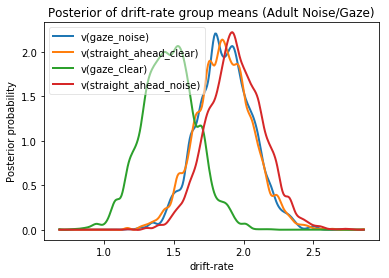

In [34]:
# plot drift
drift_gaze_noise_adult, drift_straight_ahead_clear_adult, drift_gaze_clear_adult, drift_straight_ahead_noise_adult = m_adults_ng.nodes_db.node[['v(gaze_noise)', 'v(straight_ahead_clear)', 'v(gaze_clear)', 'v(straight_ahead_noise)']]
hddm.analyze.plot_posterior_nodes([drift_gaze_noise_adult, drift_straight_ahead_clear_adult, drift_gaze_clear_adult, drift_straight_ahead_noise_adult])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means (Adult Noise/Gaze)')

Text(0.5,1,'Posterior of boundary-separation group means (Adult Noise/Gaze)')

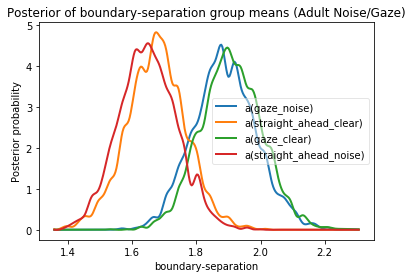

In [35]:
# plot boundary
boundary_gaze_noise_adult, boundary_straight_ahead_clear_adult, boundary_gaze_clear_adult, boundary_straight_ahead_noise_adult = m_adults_ng.nodes_db.node[['a(gaze_noise)', 'a(straight_ahead_clear)', 'a(gaze_clear)', 'a(straight_ahead_noise)']]
hddm.analyze.plot_posterior_nodes([boundary_gaze_noise_adult, boundary_straight_ahead_clear_adult, boundary_gaze_clear_adult, boundary_straight_ahead_noise_adult])
plt.xlabel('boundary-separation')
plt.ylabel('Posterior probability')
plt.title('Posterior of boundary-separation group means (Adult Noise/Gaze)')

In [120]:
ng_adults_df = model_to_df(m_adults_ng, param_list= ['a(gaze_noise)', 'a(straight_ahead_clear)', 'a(gaze_clear)', 'a(straight_ahead_noise)', 'v(gaze_noise)', 'v(straight_ahead_clear)', 'v(gaze_clear)', 'v(straight_ahead_noise)'])
ng_adults_df['experiment'] = "noise_gaze"
ng_adults_df['age_code'] = "adults"
ng_adults_df.head()

,a(gaze_clear),a(gaze_noise),a(straight_ahead_clear),a(straight_ahead_noise),v(gaze_clear),v(gaze_noise),v(straight_ahead_clear),v(straight_ahead_noise),experiment,age_code
0,2.000323,1.853591,1.636482,1.797776,1.492613,1.505116,2.024233,2.322410,noise_gaze,adults
1,2.020977,1.766205,1.758791,1.772415,1.557483,1.989070,1.768785,1.801224,noise_gaze,adults
2,1.877914,1.863204,1.903595,1.723491,1.738990,1.978440,1.696260,2.199066,noise_gaze,adults
3,1.867407,1.854289,1.879253,1.638507,1.579109,1.908307,1.504385,2.227166,noise_gaze,adults
4,1.909095,1.900873,1.803851,1.606636,1.509249,2.002647,1.988289,1.894925,noise_gaze,adults


In [122]:
ng_adults_df.to_csv("../../../data/3_final_merged_data/hddm_output/hddm_posterior_samples_ng_adults.csv", sep='\t')